In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.ensemble import IsolationForest

C:\Users\Aarush\anaconda3\Lib\site-packages\ppscore\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
#Importing Dataset
data = pd.read_csv("adult_with_headers.csv")

In [3]:
#Data Preprocessing
data = data[~data.isin(["?"]).any(axis=1)]

print(data.shape)
print(data.describe())
print(data.head())

(32561, 15)
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
   age          workclass  fnlwgt   education  educ

In [4]:
#Encoding and Scaling
cat_features = data.select_dtypes(include=["object"]).columns
num_features = data.select_dtypes(include=["int64","float64"]).columns

for col in cat_features :
    if data[col].nunique()<5:
        print(f"One Hot Encoding : {col}")
        data=pd.get_dummies(data,columns=[col],drop_first=True)
    else :
        print(f"Label Encoding : {col}")
        le = LabelEncoder();
        data[col]=le.fit_transform(data[col])

print("\nRevised data shape : ",data.shape)

scaler_std = StandardScaler()
data[num_features] = scaler_std.fit_transform(data[num_features])

scaler_mm = MinMaxScaler()
data[num_features] = scaler_mm.fit_transform(data[num_features])


Label Encoding : workclass
Label Encoding : education
Label Encoding : marital_status
Label Encoding : occupation
Label Encoding : relationship
Label Encoding : race
One Hot Encoding : sex
Label Encoding : native_country
One Hot Encoding : income

Revised data shape :  (32561, 15)


In [5]:
#PROS OF ONE-HOT ENCODING
#1.No order assumed: Works well for nominal data (categories with no natural order).

#2.Compatible with most ML algorithms: Algorithms like regression, SVM, and neural networks handle one-hot encoded features well.

#3.Prevents misleading interpretations: Since each category has its own column, the model doesn’t assume numeric relationships.


#CONS OF ONE-HOT ENCODING
#1.Increases dimensionality: If a feature has many categories, it creates many columns → sparse matrix, which can slow down training.

#2.Memory consumption: High-cardinality features (like thousands of unique values) become inefficient.

#3.Not suitable for ordinal data: Since order is lost, it may not capture ordinal relationships (e.g., Small < Medium < Large).



#PROS OF LABEL ENCODING
#1.Simple and memory-efficient: Only one column is used, no extra dimensions.

#2.Suitable for ordinal data: Preserves order if categories have natural ranking (Small < Medium < Large).

#3.Fast: Easy to implement and compute.


#CONS OF LABEL ENCODING
#1.Imposes an order on nominal data: For categories without natural order (like color), the model may think “Blue > Red”, which can mislead the algorithm.

#2.Not compatible with some algorithms: Algorithms like linear regression or distance-based models (KNN, SVM) may interpret numbers as having magnitude or distance.


In [6]:
data["Capital_Net"] = data["capital_gain"] - data["capital_loss"]

data["Hours_per_age"] = data["hours_per_week"]/data["age"]

data["Capital_gain_log"] = np.log1p(data["capital_gain"])


Data shape after removing outliers :  (32235, 18)

PPS Matrix : 
      x              y  ppscore            case  is_valid_score  \
0  age            age      1.0  predict_itself            True   
1  age      workclass      0.0      regression            True   
2  age         fnlwgt      0.0      regression            True   
3  age      education      0.0      regression            True   
4  age  education_num      0.0      regression            True   

                metric  baseline_score  model_score                    model  
0                 None        0.000000     1.000000                     None  
1  mean absolute error        0.756400     0.889262  DecisionTreeRegressor()  
2  mean absolute error        0.052645     0.053588  DecisionTreeRegressor()  
3  mean absolute error        2.724400     2.764712  DecisionTreeRegressor()  
4  mean absolute error        0.125067     0.127564  DecisionTreeRegressor()  


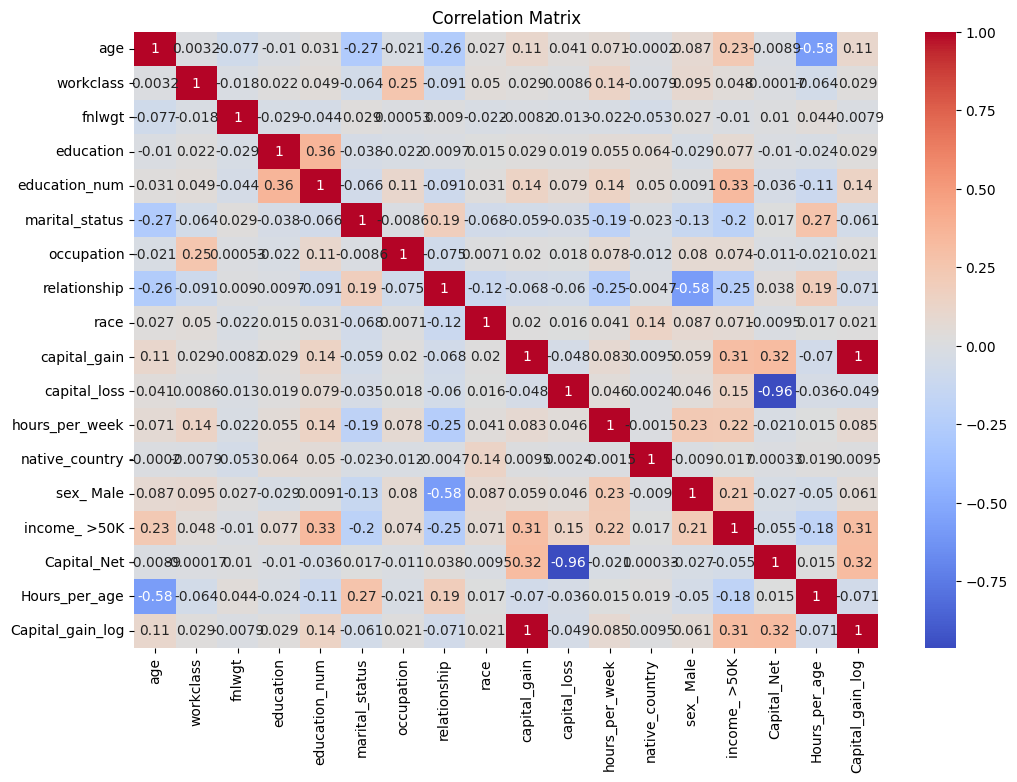


Final Processed Dataset Shape :  (32235, 18)
        age  workclass    fnlwgt  education  education_num  marital_status  \
0  0.301370          7  0.044302          9       0.800000               4   
1  0.452055          6  0.048238          9       0.800000               2   
2  0.287671          4  0.138113         11       0.533333               0   
3  0.493151          4  0.151068          1       0.400000               2   
4  0.150685          4  0.221488          9       0.800000               2   

   occupation  relationship  race  capital_gain  capital_loss  hours_per_week  \
0           1             1     4       0.02174           0.0        0.397959   
1           4             0     4       0.00000           0.0        0.122449   
2           6             1     4       0.00000           0.0        0.397959   
3           6             0     2       0.00000           0.0        0.397959   
4          10             5     2       0.00000           0.0        0.397959   

In [7]:
#Creating Isolation Forest Model
iso = IsolationForest(contamination=0.01,random_state=42)
outliers = iso.fit_predict(data[num_features])
data["outlier"] = outliers

data_clean = data[data["outlier"] == 1].drop('outlier',axis=1)
print("\nData shape after removing outliers : ",data_clean.shape)

pps_matrix = pps.matrix(data_clean)
print("\nPPS Matrix : \n",pps_matrix.head())

corr_matrix = data_clean.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

print("\nFinal Processed Dataset Shape : ",data_clean.shape)
print(data_clean.head())